# King County Housing Price Analysis

#### CRISP-DM Data Science Process

# Business Understanding

The goal of this analysis is to create a model that can be used by realtors in the King County area to successfully predict the price of homes using location-based and home-based features. These models will predict home prices and describe the linear dependancy of price on each of the features. The features come from the data we are given to complete this project. 

The stakeholders in this analysis are realtors. The intention is they use the information to understand and describe to home buyers and sellers which features of a home influence its cost.

The scope of the analysis is determined by the data. Predicting price based on features like square footage, floors, zipcode, etc is within the scope of this analysis. Predicting home prices outside the range of the data we have, e.g. outside King County, is not wihtin the scope of this analysis.

# Data Understanding

The housing data for this project comes from Kings County, Washington. The county encompasses the  area of greater Seattle. 

In [1]:
# The usual imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
# Will be using stats models to inspect p-values for features
import statsmodels.api as sm

In [3]:
# SkLearn is how the data will be scaled, split into training and testing sets, modeled, and validated.

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
df = pd.read_csv('data/kc_house_data.csv')

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### *Target and Predictors*

The target in the data we would like to predict is price of the home.

We have access to all the columns listed above to use as predictors. In this group project, the analysis will be broken into two parts, a model using house features as predictors (Tosca) and a model using location-based features as the predictors (Jonny). This notebook is the analysis for the latter, location based model.

I plan on focusing on using zipcode location for this model, but will also need to use other features to account for information that zipcode does not. Waterfront and the lot size of neighboring homes are features I would consider to be 'location based'. But since the majority of price of a home is determined by house and lot square footage, those columns are necessarily included. With home and lot size accounting for most of the variation in price (as they should), I want the model to clealy show how much the location predictors influence price on top of that. 

In [6]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

## *Addressing Model Assumptions*

The first step after selecting predictors is to examine the distributions of parameters to search for multicolinearity, proper scaling, and things like outliers. 

First let's plot the distributions of the location parameters we are interested in (not including the lat, long, and categoricals zipcode and waterfront).

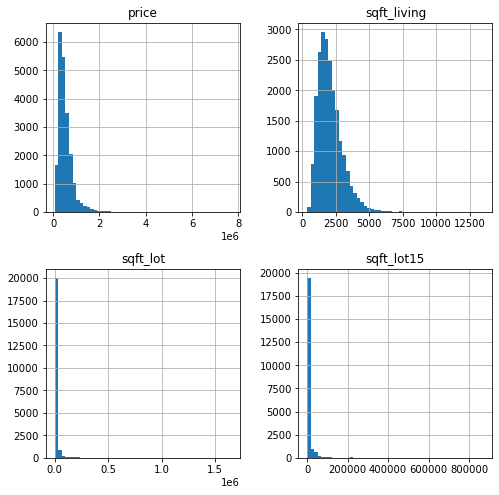

In [7]:
df.hist(column=['price', 'sqft_living', 'sqft_lot', 'sqft_lot15'], figsize=(8,8), bins=50);

All of these features are not quite normally distributed. sqft_living is the most normal but with a tail on the right. Let's see how they look if we log transform them. 

In [8]:
log_df = pd.DataFrame()
non_normal = ['price', 'sqft_living', 'sqft_lot', 'sqft_lot15']
for feat in non_normal:
    log_df['log_'+feat] = df[feat].map(lambda x: np.log(x))

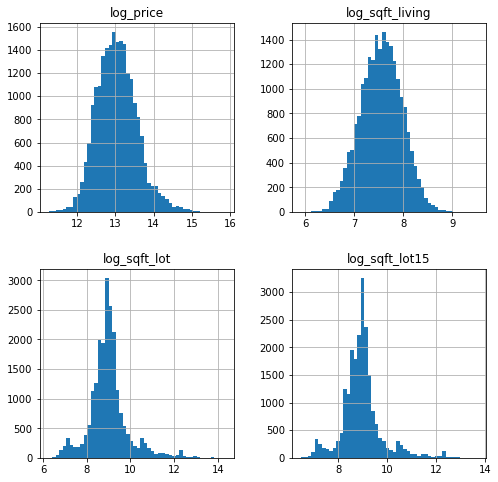

In [9]:
log_df.hist(figsize=(8,8), bins=50);

Now our features looks normally distributed. This is not an essential step, but can be used to improve the model prediction accuracy compared to using non-normal features. In my earier data exploration while comparing models I found that using raw predictor data wasn't quite hitting the desired r-squared value I wanted, and using log tranformations was able to improve r^2 by about 0.1 on average. In the end, I will need to un-transform the price target so the information is qualitative and presentable. 

### *Outliers and trimming*

Based on these histograms and other exploration, I think the data *could* be trimmed slightly. But the skews are not so bad, and if the model can still predict successfully with all data than that is obviously preferred. I would personally prefer to use log tranforming to improve the fit of the model than to remove entire zipcodes to improve fit.

#### *Are certain zipcodes outliers?*
The distributions of lot square footage above brought up the point that maybe certain zipcodes are mostly farmland and skew the sqft_lot distribution. It would be ideal to have a model that can account for this, but just in case we should find out which zipcodes those might be. Then after doing the regression, if those zipcodes didn't perform well as predictors it might be best to remove those zipcodes from th data and just try to predict home prices for similar suburbian zipcodes. Because price is the target, I am also going to look at average price per zipcode as a sanity check.

<ipython-input-10-5da81e16cba7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
<ipython-input-10-5da81e16cba7>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=zips_str, rotation=60, size=8.5)


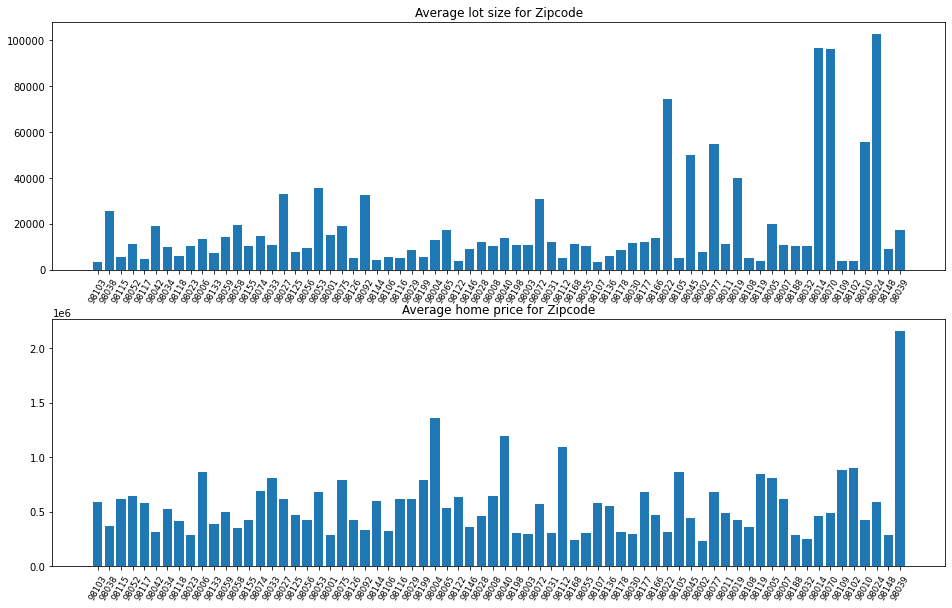

In [10]:
zips_int = list(df['zipcode'].value_counts().index)
zips_str = list(map(str, zips_int))

avg_lot = [df[df['zipcode']==z]['sqft_lot'].mean() for z in zips_int]
avg_price = [df[df['zipcode']==z]['price'].mean() for z in zips_int]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10))

ax1.bar(zips_str, avg_lot)
ax1.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
ax1.set_title('Average lot size for Zipcode')

ax2.bar(zips_str, avg_price)
ax2.set_xticklabels(labels=zips_str, rotation=60, size=8.5)
ax2.set_title('Average home price for Zipcode');

It does appear that several zipcodes have significantly higher lot sizes than the others. 98022, 98014, 98070, and 98024 are the most outlier-ish. That is Enumclaw, Carnation, Vashon and Fall City respectively. These zips are the areas East of Seattle as suburbs turn to farmlands turn to mountains. Except for Vashon, which is an island southwest of downtown Seattle. 

Price seems to be fairly consistent between zipcode, save for one. 98039 is Medina, a lakeside are of Bellvue. Must be some expensive homes there. I wondered if this zip contained a lot of the waterfront properties, but as you can see in the next sub-section it does not. High housing price in this area must be due to something other than waterfront and we shouldn't have to worry about multicolinearity.

#### *Is waterfront equally distributed through zipcodes?*
There are only a few rows with waterfront == 1. Are they worth keeping around?

In [11]:
# count the number of zipcode values in a dataframe where waterfront is true
len(df[df['waterfront']==1]['zipcode'].value_counts().index)

29

So even though there are few rows with waterfront proerties (146), they are represented in 29/70 of the King County zipcodes. This is good because we now know waterfront is not colinear with a certain zipcode and we can attempt to use it as a predictor. 

Again, I would prefer a model that can explain these features as I am trying to predict based on location details. Maybe the waterfront column will help to explain some high priced outliers and leave the rest of the model to fit better. Just as I described above, my process will be to leave waterfront properties in for te first models. If it turns out they are not good predictors and hinder the rest of the model, we can go back and remove them and try to fit more constrained data. 

#### *To trim or not to trim?*
I have decided to leave in all the waterfront properties, farmland zipcodes, and high priced homes. If this model wants to learn based on location why would we want to remove all the intersting data. This was a good check to understand the features and look for subtle colinearities. If and only if the model cannot successfully predict the variance in these groups, then as in the *Evaluate* step of CRISP-DM says, I will go back and remove inconsistencies until prediction improves. This model will be referred to as the 'constrained' model.

### *Multicolinearity*

We have already explored multicolinearity in the categorical variables zipcode and waterfront above, so now let's use seaborns pairplot to look to colinearity in the continuous variables. 

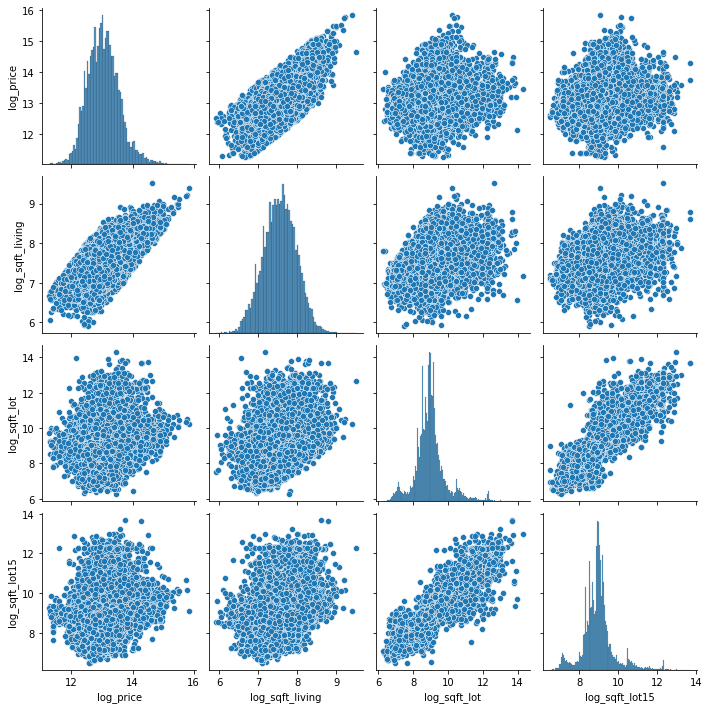

In [12]:
pair = pd.concat([log_df])
sns.pairplot(pair);

Interestingly, the square footage of the living space and lot space don't seem to be very colinear. But lot sqft and neighboring 15 lot sqft do seem to have a linear trend to them. To address this issue the columns could be combined into the ratio of the two, lot size/neighbor lot size. Values over 1 would suggest a the house's lot is larger than the average neighbors, while a value less than 1 indicates a smaller lot size than the neighbors. I like this combination as it contains a good amount of 'location' information. Rather than just lot size, we now can see this in context as lot size compared to surrounding neighbors.

### Zipcode and Lat/Long

Do deal with catgorical zipcode data in the regession, it will be one-hot encoded in the next section. I have created a dictionary to generalize zipcode areas by Seattle sub-city. For example, rather than each downtown or Bellvue area zipcode being separate, they have been grouped into areas, downtown and Bellvue each containing a few zipcodes. I have done this for ease of sharing results, and because zipcodes can tend to geographically not represent areas very well. Many zipcodes cut suburbs right down the middle. So I have opted to 'zoom out' a bit from zipcode, and combine them into larger groups where I have seen necessary.

The sub-city zipcode dictionary will be intoduced in the next section where I do the data prep, but I should mention here where I got the specific location information and maps I used to group the zipcodes. [Zipdatamaps](https://www.zipdatamaps.com/king-wa-county-zipcodes) is the link to the Kings County zipcodes and an interactive map. I used the map and my knowedge of the Seattle area to create the groups you'll find in the dictionary below.

To incorporate the Lat/Long data, I am going to create a measure of how far the home location is from the center of downtown Seattle. This metric would show if thre is a trend of home price based on proximity to downtown. There is risk of multicolinearity here with the zipcode groups, so I will check the model performance with and without this feature. If they appear to be colinear then I may create two separate models, one that uses only area and one that only uses distance to downtown and compare performance. In the next section is where I will make the transformation into a new colunmn. 


# Data Preparation

#### *Basic cleaning*

Now that the plan for how to use the data has been outlined above, below I make the actual transformations and one-hot encoding after some basic cleaning and selecting of columns.

In [13]:
# Right off the bat lets remove houses that are in the dataset twice by removing duplicated in the 'id' column
df.duplicated('id').value_counts()

False    21420
True       177
dtype: int64

In [14]:
df.drop_duplicates(subset='id', inplace=True)

There are also NaN values in the waterfront column, need to get rid of these to perform the regression. This unfortunately removes 2353 rows from the data. But waterfront is an important location factor. If it ends up not being a good predictor and it is removed, these NaN rows will be added back in to the data

In [15]:
df['waterfront'].isna().value_counts()

False    19067
True      2353
Name: waterfront, dtype: int64

In [16]:
df.dropna(subset=['waterfront'], inplace=True)

Also want to drop an outlier Tosca is removing from her data. The 33 bedroom house.

In [110]:
df = df[df['bedrooms'] < 33]

#### *Lot Ratio Column*
All three models will use the log transformed continuous features and the ratio of lot to neighbor lots, so I will first create and update those in 'df' so they all apply to the 3 dataframes created from 'df' after.

In [17]:
# Create a column that is the ratio of lot size to neighbor lot size

df['sqft_lot_ratio'] = df['sqft_lot']/df['sqft_lot15']

In [18]:
# Note that many of the homes must be in neighborhoods that must have all the exact same lot size and thus a 
# ratio of 1. Let's check exactly how many 1.

len(df[df['sqft_lot_ratio']==1]) / len(df)

0.20690197723816017

20% of the data is homes in neighborhoods with identical lot sizes. I think that 80% of the data that does have a different is enough to continue using this metric and I will move on with it.

Plot a histogram first to see if this new ratio column is one I'd like to scale or log transform.

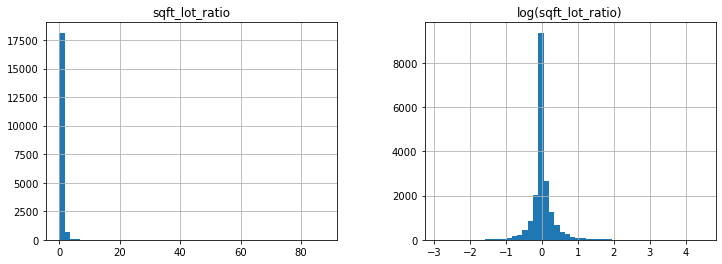

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df.hist('sqft_lot_ratio', ax = ax1, bins=50)

lg = np.log(df['sqft_lot_ratio'])
lg.hist(ax = ax2, bins=50)

ax2.set_title('log(sqft_lot_ratio)');

It's not very normal (as expected, its the ratio of two other non-normal variables). The log transformation looks like it might be a good option if we need ways to increase the coefficient of determination for the models, but it is very sharply peaked at 0 as 20% of the values are '1'.

#### *Log transforming columns*

In [20]:
# creating log transformed columns

log_feats = ['price', 'sqft_living', 'sqft_lot_ratio']
for feat in log_feats:
    df['log_'+feat] = np.log(df[feat])

### *Train Test Split*
This is the best place to split the data into training and testing sets. Doing it on the original df ensures each of the three following dataframes and models are training and testing on the same split, ensuring we can accurately evaluate and compare the models. 

In [22]:
# first split the target (y) from the predictors (X)

y_df = df['log_price']
X_df = df.drop('log_price', axis=1)
# Note I am leaving all the columns in the X_df because I select from them differently for each model.


In [23]:
# Now use sklearn to split the df into training and testing

X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(
    X_df, y_df, test_size=0.25, random_state=42)

The columns will be scaled once each dataframe is created.

### *Creating dataframes for the different models*

Since I want to compare 3 different ways to deal with location in the model, I am going to create 3 separate dataframes in order to easily do each. 

Each model will target price, and still include sqft_living, the ratio of sqft_lot to sqft_lot15 (neighbor lot), and waterfront. The difference between the dataframes and models are detailed below.

1. The first model will use zipcode and one-hot encode right from the zips listed in the data.
2. The second model generalizes the zipcodes into the different sub-cities of Seattle I have defined and then one-hot encodes them.
3. The third model will use lat/long to compute a distance from city center and use this in place of a zip location.

All three models will be compared in the results and the one that performs best will be used for analysis and to answer the business questions. I will create each of these 3 dataframes from 'df' but give them different names so they can easily by input into the linear regression functions separately. The first will be called 'zip_df' as it uses raw zipcodes. The second will be called 'kc_df' as it uses the different cities within King County instead of zipcode. The third dataframe will be called 'll_df' for the lat/long metric it uses. 

Note: as mentioned in the previous section, a 4th 'constrained' model may also be created if these three cannot successfully account for the variation.

### *Zipcode model prep*

Selecting the desired columns from X_df_train, scale them, and then one-hot encoding the zipcodes.

In [40]:
# identify the columns needed for this df
zip_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'zipcode']

# create the df for this model
zip_df = X_df_train[zip_cols]

In [51]:
# use Standard Scalar to scale the two continuous columns, log_sqft_living and log_sqft_lot_ratio
# I am also using column transformer to make sure the other columns are left the same

ct = ColumnTransformer([
        ('zip_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio'])
    ], remainder='passthrough')

zip_df_scaled = pd.DataFrame(ct.fit_transform(zip_df), columns=zip_cols)

In [52]:
zip_df_scaled.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,zipcode
0,0.751459,-1.265267,0.0,98056.0
1,0.083680,-0.084145,0.0,98040.0
2,-0.076065,-0.084145,0.0,98053.0
3,-1.036194,-1.087464,0.0,98042.0
4,0.973213,-3.899670,0.0,98006.0


In [53]:
# Here I will use Pandas get dummy variable function to encode zips

zip_dummies = pd.get_dummies(zip_df_scaled['zipcode'], prefix='zip', drop_first=True)
zip_normals = zip_df_scaled.drop('zipcode', axis=1)
zip_X_train_scaled = pd.concat([zip_normals, zip_dummies], axis=1)
zip_X_train_scaled.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,zip_98002.0,zip_98003.0,zip_98004.0,zip_98005.0,zip_98006.0,zip_98007.0,zip_98008.0,...,zip_98146.0,zip_98148.0,zip_98155.0,zip_98166.0,zip_98168.0,zip_98177.0,zip_98178.0,zip_98188.0,zip_98198.0,zip_98199.0
0,0.751459,-1.265267,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.083680,-0.084145,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.076065,-0.084145,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.036194,-1.087464,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.973213,-3.899670,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The same thing needs to be done to the X_test data

In [55]:
# Select columns for test
zip_df_test = X_df_test[zip_cols]

# Transform it using the scaler fit to the training data
zip_df_test_scaled = pd.DataFrame(ct.transform(zip_df_test), columns=zip_cols)

# Then create the same dummy variables as above
zip_dummies_test = pd.get_dummies(zip_df_test_scaled['zipcode'], prefix='zip', drop_first=True)
zip_normals_test = zip_df_test_scaled.drop('zipcode', axis=1)
zip_X_test_scaled = pd.concat([zip_normals_test, zip_dummies_test], axis=1)

The zip_X_train dateframe is now ready to be train/test split and input to regression along with the target y_df_train which will be the same for all models.

### *City model prep*

For the city/suburb model I have created a dictionary to attach city labels to zipcodes. Initialize it below.

In [33]:
 suburb_dict = {
               'Auburn': [98001, 98002, 98092],
               'Ballard': [98117, 98107],
               'Baring': [98224],
               'Bellevue': [98004, 98005, 98006, 98007, 98008],
               'Black Diamond': [98010],
               'Bothell': [98011],
               'Broadview': [98177, 98133],
               'Buckley': [98321],
               'Burien': [98146, 98148, 98166, 98168],
               'Capital Hill': [98102, 98112],
               'Carnation': [98014],
               'Cle Elum': [98922],
               'Covington': [98042],
               'Delridge': [98106],
               'Des Moines': [98198],
               'Duvall': [98019],
               'Enumclaw': [98022],
               'Fall City': [98024],
               'Federal Way': [98003],
               'Gold Bar': [98251],
               'Greenwood': [98103],
               'Issaquah': [98027, 98029],
               'Kenmore': [98028],
               'Kent': [98030, 98031, 98032],
               'Kirkland': [98033, 98034],
               'Lake City': [98125],
               'Lake Forest Park': [98155],
               'Leavenworth': [98826],
               'Madrona': [98122],
               'Magnolia': [98199],
               'Maple Valley': [98038],
               'Medina': [98039],
               'Mercer Island': [98040],
               'Milton': [98054],
               'Mount Baker': [98144],
               'North Bend': [98045],
               'Northeast Seattle': [98115],
               'Pacific': [98047],
               'Ravensdale': [98051],
               'Rainier Valley': [98108, 98118],
               'Redmond': [98052, 98053],
               'Renton': [98055, 98056, 98057, 98058, 98059, 98178],
               'Sammamish': [98074, 98075],
               'Seattle': [98134, 98101, 98104, 98121, 98131, 98132, 98154, 98158, 98561, 98164, 98174],
               'Skyomish': [98288],
               'Snoqualmie': [98065],
               'Tukwila': [98188],
               'Queen Anne': [98119, 98109],
               'University': [98105, 98195],
               'Vashon': [98070],
               'West Seattle': [98116, 98126, 98136],
               'Woodinville': [98072]
               }

In [34]:
pd.options.mode.chained_assignment = None

In [35]:
kc_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'zipcode']
kc_df_train = X_df_train[kc_cols]

for key, values in suburb_dict.items():
    kc_df_train[key] = kc_df_train['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
kc_df_train.drop('zipcode', axis=1, inplace=True)

Let's check and see how many rows are in each King County city

In [36]:
sub = [key for key, value in suburb_dict.items()]

for s in sub:
    ct = len(kc_df_train[kc_df_train[s]==1])
    print(s, ct)

Auburn 602
Ballard 550
Baring 0
Bellevue 942
Black Diamond 66
Bothell 135
Broadview 490
Buckley 0
Burien 562
Capital Hill 257
Carnation 82
Cle Elum 0
Covington 348
Delridge 216
Des Moines 171
Duvall 116
Enumclaw 156
Fall City 57
Federal Way 185
Gold Bar 0
Greenwood 417
Issaquah 494
Kenmore 196
Kent 434
Kirkland 659
Lake City 258
Lake Forest Park 283
Leavenworth 0
Madrona 196
Magnolia 216
Maple Valley 391
Medina 33
Mercer Island 187
Milton 0
Mount Baker 231
North Bend 143
Northeast Seattle 375
Pacific 0
Ravensdale 0
Rainier Valley 457
Redmond 646
Renton 1215
Sammamish 527
Seattle 0
Skyomish 0
Snoqualmie 215
Tukwila 88
Queen Anne 198
University 154
Vashon 79
West Seattle 627
Woodinville 175


There are multiple areas I have defined that do not have zips included in this data. Gold Bar, Cle Elum, Leavenworth, Buckley, and Milton all have zero entries; but the all have King County as a 'secondary county', so removing them has no consequence. Skyomish, Ravesdale, Baring, Pacific, and Downtown Seattle also have no entries, but King County is their primary county. 

Removing all these wont have an effect on the model, but I will do it for cleanliness. Removing the suburbs that strictly are part of King County does have an effect on the scope of this model. I can no longer say it can predit home price across the entire county. There is no data for downtown Seattle, and the eastern rural areas of Kings County (of which Snoqualmie, Ravensdale, Baring, Pacific are part of) are underepresented in the data compared to their portion of King County. This is a limitation that will effect how we predict the prices in the similar rural counties like Woodinville and Snoqualmie. This limitation makes a case for using the constrained model and removing all counties with large rural properties and just focusing on suburban King County/Seattle. We wont be able to as confidently predict the price of rural homes within the entire desired scope of the analysis. But we can at least try first. So rural counties that do have data will be left in, but if they do not perform well as predictors, we will try the constrained model.

Below we delete the subrubs that contain zero data points.

In [37]:
to_del = ['Gold Bar', 'Cle Elum', 'Leavenworth', 'Buckley', 'Milton', 'Skyomish', 'Ravensdale', 'Baring', 'Pacific', 'Seattle']

for d in to_del:
    suburb_dict.pop(d)

In [64]:
# and recreate the kc_df without empty regions, for both training and testing sets
kc_X_train = X_df_train[kc_cols]
kc_X_test = X_df_test[kc_cols]

# one hot encode with updated dictionary, both training and testing sets
for key, values in suburb_dict.items():
    kc_X_train[key] = kc_X_train['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
for key, values in suburb_dict.items():
    kc_X_test[key] = kc_X_test['zipcode'].map(lambda x: 1 if (x in values) else 0)
    
    
kc_X_train.drop('zipcode', axis=1, inplace=True)
kc_X_test.drop('zipcode', axis=1, inplace=True)

In [65]:
kc_X_train.head()

,log_sqft_living,log_sqft_lot_ratio,waterfront,Auburn,Ballard,Bellevue,Black Diamond,Bothell,Broadview,Burien,...,Redmond,Renton,Sammamish,Snoqualmie,Tukwila,Queen Anne,University,Vashon,West Seattle,Woodinville
20346,7.874739,-0.426726,0.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2795,7.590852,0.000000,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21015,7.522941,0.000000,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10094,7.114769,-0.362488,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20580,7.969012,-1.378506,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now to scale these training and testing sets. We unfortunately can't use the same transformer object we created above since the dataframe has conflicting remainder columns, even if the ones we are interested in scaling are the same. So instantiate a new column transformer for the kc df.

In [66]:
ct_kc = ColumnTransformer([
        ('kc_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio'])
    ], remainder='passthrough')

kc_X_train_scaled = pd.DataFrame(ct_kc.fit_transform(kc_X_train), columns=list(kc_X_train.columns))
kc_X_test_scaled = pd.DataFrame(ct_kc.transform(kc_X_test), columns=list(kc_X_test.columns))

Okay, now the King County cities dataframe is ready.

### *Lat/Long model prep*

In place of zipcode or area, this model computes the distance the home is from Seattle city center based on the given Latitude and Longitude. I am trying this to see if proximity to downtown has an influence on price.

To easily compute a distance in miles from the lat/longs I am using GeoPy package's geodesic distance function.

In [72]:
import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.geodesic(coords_1, coords_2).miles)

173.5818455248231


For Seattle city center, I have decided to use the coordinates for Pikes Place Market, a main attraction in the very center of the downtown.

In [73]:
seattle_ll = (47.6097, -122.3422)

In [74]:
# Use apply and map functions to create lat/long column and then proximity column using the geopy function
# Do for both training and testing
ll_X_train = X_df_train # better practice to not manipulate our original train df
ll_X_test = X_df_test

ll_X_train['ll'] = ll_X_train.apply(lambda x: (x['lat'], x['long']), axis=1)
ll_X_train['prox'] = ll_X_train['ll'].map(lambda x: geopy.distance.geodesic(seattle_ll, x).miles)

ll_X_test['ll'] = ll_X_test.apply(lambda x: (x['lat'], x['long']), axis=1)
ll_X_test['prox'] = ll_X_test['ll'].map(lambda x: geopy.distance.geodesic(seattle_ll, x).miles)

In [37]:
ll_X_train['log_prox'] = np.log(ll_X_train['prox'])

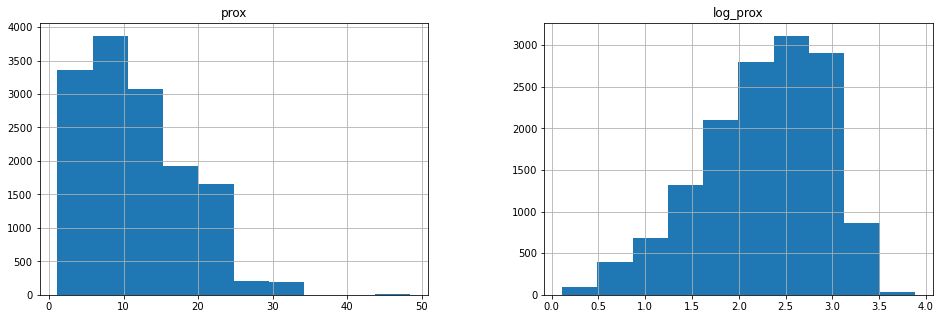

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ll_X_train.hist('log_prox', ax=ax2)
ll_X_train.hist('prox', ax=ax1);

Taking the log of the proximity doesnt make this feature look more normal. I will use the normal distance in miles for the linear model.

In [75]:
# define the columns to be used in the lat/long model. Same original 3 plus the prox

ll_cols = ['log_sqft_living', 'log_sqft_lot_ratio', 'waterfront', 'prox']

ll_X_train = ll_X_train[ll_cols]
ll_X_test = ll_X_test[ll_cols]

,log_sqft_living,log_sqft_lot_ratio,waterfront,prox
20346,7.874739,-0.426726,0.0,10.720477
2795,7.590852,0.000000,0.0,6.059765
21015,7.522941,0.000000,0.0,16.228043
10094,7.114769,-0.362488,0.0,18.458349
20580,7.969012,-1.378506,0.0,10.906042


In [76]:
# now column transform to scale features

ct_ll = ColumnTransformer([
        ('ll_transform', StandardScaler(), ['log_sqft_living', 'log_sqft_lot_ratio', 'prox'])
    ], remainder='passthrough')

ll_X_train_scaled = pd.DataFrame(ct_ll.fit_transform(ll_X_train), columns=list(ll_X_train.columns))
ll_X_test_scaled = pd.DataFrame(ct_ll.transform(ll_X_test), columns=list(ll_X_test.columns))

Looks good, this dataframe is ready for modeling.

## Modeling

### *FSM*

Begin with setting the baseline model. 

In [77]:
baseline = y_df_train.mean()

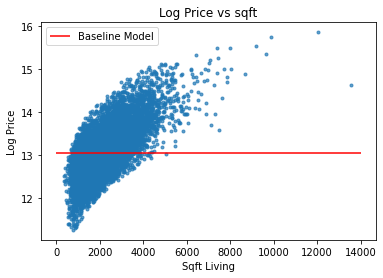

In [78]:
plt.scatter(X_df_train['sqft_living'], y_df_train, alpha=0.7, marker='.')
plt.hlines(baseline, -1, 14000, color='r', label='Baseline Model')
plt.title('Log Price vs sqft')
plt.xlabel('Sqft Living')
plt.ylabel('Log Price')
plt.legend();


In [104]:
baselines = [baseline for x in range(len(y_df_test))]

r2_baseline = r2_score(y_df_test, baselines)
print(f"Baseline R-squared: {r2_baseline:.3f}")
print(f"Baseline RMSE: {mean_squared_error(y_df_test, baselines, squared=False):.3f}")

Baseline R-squared: -0.000
Baseline RMSE: 0.521


The FSM naive model predicts the average price across all homes. The coefficient of determination for the FSM is below zero. Hopefully we can do better than that. 

### *Zipcode Model*

In [93]:
y_df_train.reset_index(drop=True, inplace=True)
y_df_test.reset_index(drop=True, inplace=True)

In [106]:
X = zip_X_train_scaled
# scaling messed with index so we need to reset y so they match
y = y_df_train

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     991.9
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:01:46   Log-Likelihood:                 1635.1
No. Observations:               14300   AIC:                            -3124.
Df Residuals:                   14227   BIC:                            -2572.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.5210      0.014    877.185      0.000      12.493      12.549
log_sqft_living        0.3090      0.002    151.662      0.000       0.305       0.313
log_sqft_lot_ratio     0.0175      0.002      9.519      0.000       0.014       0.021
waterfront             0.8018      0.022     37.160      0.000       0.760       0.844
zip_98002.0           -0.0300      0.024     -1.269      0.204      -0.076       0.016
zip_98003.0            0.0538      0.021      2.518      0.012       0.012       0.096
zip_98004.0            1.2529      0.021     60.681      0.000       1.212       1.293
zip_98005.0            0.8378      0.025     34.112      0.000       0.790       0.886
zip_98006.0            0.8025      0.019     43.029      0.000       0.766       0.839
zip_98007.0            0.7304      0.027     27.347      0.000       0.678       0.783
zip_98008.0            0.6888      0.021     32.155      0.000       0.647       0.731
zip_98010.0            0.3358      0.030     11.111      0.000       0.277       0.395
zip_98011.0            0.4608      0.023     19.628      0.000       0.415       0.507
zip_98014.0            0.4076      0.028     14.643      0.000       0.353       0.462
zip_98019.0            0.3447      0.025     13.981      0.000       0.296       0.393
zip_98022.0            0.1607      0.022      7.158      0.000       0.117       0.205
zip_98023.0           -0.0034      0.019     -0.183      0.855      -0.040       0.033
zip_98024.0            0.4945      0.032     15.444      0.000       0.432       0.557
zip_98027.0            0.5837      0.019     30.206      0.000       0.546       0.622
zip_98028.0            0.4307      0.021     20.472      0.000       0.389       0.472
zip_98029.0            0.6647      0.021     32.395      0.000       0.625       0.705
zip_98030.0            0.0411      0.022      1.872      0.061      -0.002       0.084
zip_98031.0            0.0843      0.022      3.913      0.000       0.042       0.126
zip_98032.0           -0.0078      0.027     -0.283      0.777      -0.062       0.046
zip_98033.0            0.8575      0.019     44.584      0.000       0.820       0.895
zip_98034.0            0.5867      0.018     32.382      0.000       0.551       0.622
zip_98038.0            0.1907      0.018     10.601      0.000       0.155       0.226
zip_98039.0            1.5177      0.040     37.545      0.000       1.438       1.597
zip_98040.0            1.0396      0.021     48.491      0.000       0.998       1.082
zip_98042.0            0.1008      0.018      5.479      0.000       0.065       0.137
zip_98045.0            0.3953      0.023     17.155      0.000       0.350       0.441
zip_98052.0            0.6914      0.018     38.145      0.000       0.656       0.727
zip_98053.0            0.6611      0.0

Checking the p-value column for accuracy of the predictors we can see that certain zipcodes do not describe the variance in their data. These zipcodes are 98002 (Auburn area), 98003, 98023 (both in Federal Way area), and 98032 (a Kent zip). 

I will now use an SkLearn linear regression model to see how we performed on the testing set.

In [107]:
# model
zip_model = LinearRegression()

zip_model.fit(zip_X_train_scaled, y_df_train.reset_index(drop=True))


# predictions
train_preds_zip = zip_model.predict(zip_X_train_scaled)
test_preds_zip = zip_model.predict(zip_X_test_scaled)

In [108]:
print(f"Train R2 Score: {r2_score(y_df_train, train_preds_zip):.3f}")
print(f"Test R2 Score: {r2_score(y_df_test, test_preds_zip):.3f}")
print("-----")
print(f"Train RMSE: {mean_squared_error(y_df_train, train_preds_zip, squared=False)}")
print(f"Test RMSE: {mean_squared_error(y_df_test, test_preds_zip, squared=False)}")

Train R2 Score: 0.834
Test R2 Score: 0.836
-----
Train RMSE: 0.21582676046452168
Test RMSE: 0.21131440387374806


In [109]:
# Use the print metrics function kindly provided by Lindsey to see the RMSE in terms of $$ and not log($)
print_metrics(y_df_train, train_preds_zip, y_df_test, test_preds_zip, log=True)

Training Scores
----------
R2: 0.8339
RMSE: 170535.3092
MAE: 91142.7151

**********
Testing Scores
----------
R2: 0.8357
RMSE: 147795.1284
MAE: 84900.9801


The model fits very well, but a RMSE of 147 thousand dollars is very high in context. 

### *KC Model*

In [90]:
X = kc_X_train_scaled
y = y_df_train

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1295.
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:17:58   Log-Likelihood:                 433.07
No. Observations:               14300   AIC:                            -774.1
Df Residuals:                   14254   BIC:                            -426.0
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.6846      0.011   1169.501      0.000      12.663      12.706
log_sqft_living        0.3241      0.002    149.467      0.000       0.320       0.328
log_sqft_lot_ratio     0.0149      0.002      7.478      0.000       0.011       0.019
waterfront             0.7835      0.023     33.553      0.000       0.738       0.829
Auburn                -0.1323      0.014     -9.138      0.000      -0.161      -0.104
Ballard                0.7028      0.015     47.335      0.000       0.674       0.732
Bellevue               0.7073      0.013     53.200      0.000       0.681       0.733
Black Diamond          0.1716      0.031      5.553      0.000       0.111       0.232
Bothell                0.2933      0.023     12.777      0.000       0.248       0.338
Broadview              0.3889      0.015     25.579      0.000       0.359       0.419
Burien                 0.0738      0.015      4.995      0.000       0.045       0.103
Capital Hill           0.9558      0.018     52.399      0.000       0.920       0.992
Carnation              0.2445      0.028      8.687      0.000       0.189       0.300
Covington             -0.0612      0.017     -3.680      0.000      -0.094      -0.029
Delridge               0.1931      0.019      9.931      0.000       0.155       0.231
Des Moines            -0.0490      0.021     -2.327      0.020      -0.090      -0.008
Duvall                 0.1776      0.024      7.286      0.000       0.130       0.225
Enumclaw               0.0029      0.022      0.135      0.892      -0.040       0.046
Fall City              0.3306      0.033     10.026      0.000       0.266       0.395
Federal Way           -0.1077      0.020     -5.276      0.000      -0.148      -0.068
Greenwood              0.6991      0.016     44.003      0.000       0.668       0.730
Issaquah               0.4503      0.015     29.732      0.000       0.421       0.480
Kenmore                0.2662      0.020     13.317      0.000       0.227       0.305
Kent                  -0.1121      0.016     -7.156      0.000      -0.143      -0.081
Kirkland               0.5385      0.014     37.942      0.000       0.511       0.566
Lake City              0.4254      0.018     23.287      0.000       0.390       0.461
Lake Forest Park       0.2889      0.018     16.289      0.000       0.254       0.324
Madrona                0.6938      0.020     34.644      0.000       0.655       0.733
Magnolia               0.7689      0.019     39.786      0.000       0.731       0.807
Maple Valley           0.0250      0.016      1.555      0.120      -0.007       0.057
Medina                 1.3320      0.042     31.392      0.000       1.249       1.415
Mercer Island          0.8624      0.020     42.282      0.000       0.822       0.902
Mount Baker            0.5495      0.0

Looking at the p-value row, we can see that everything predicted well except for the Enumclaw and Maple Valley areas.

### *Lat/Long Model*

In [91]:
X = ll_X_train_scaled
y = y_df_train

model = sm.OLS(y, sm.add_constant(X))

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     6738.
Date:                Mon, 14 Jun 2021   Prob (F-statistic):               0.00
Time:                        18:18:03   Log-Likelihood:                -3622.9
No. Observations:               14300   AIC:                             7256.
Df Residuals:                   14295   BIC:                             7294.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.0478      0.003   4985.525      0.000      13.043      13.053
log_sqft_living        0.3776      0.003    142.356      0.000       0.372       0.383
log_sqft_lot_ratio     0.0084      0.003      3.170      0.002       0.003       0.014
waterfront            -0.2257      0.003    -85.686      0.000      -0.231      -0.221
prox                   0.7125      0.031     23.355      0.000       0.653       0.772
==============================================================================
Omnibus:                      108.237   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.991
Skew:                          -0.112   Prob(JB):                     5.40e-32
Kurtosis:                       3.437   Cond. No.                         13.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluation

## Deployment

In [ ]:
x_cols = ['price', 'sqft_living', 'sqft_lot', 'waterfront', 'zipcode', 'lat', 'long', 'sqft_lot15']
df = df[x_cols]

In [105]:
def print_metrics(y_tr, tr_pred, y_te, te_pred, log=False):
    '''
    Prints the R2 Score, Mean Absolute Error and Root Mean Squared Error
    Will unlog to get MAE & RMSE in terms of the original target if log=True
    
    Inputs:
        y_tr: array-like or pandas series
            Actual target values for the train set
        tr_pred: array-like or pandas series
            Predicted target values for the train set
        y_te: array-like or pandas series
            Actual target values for the test set
        te_pred: array-like or pandas series
            Predicted target values for the test set
        log: boolean
            Toggles whether the target values have been logged or not
            If True, assumes all other arguments passed into the function have been logged
            
    Outputs:
        None, just prints the metrics
    '''
    # Unlogging all variables if you set log=True
    if log == True:
        # Please note - if you used log to log the variables, change this to exp
        y_tr_unlog = np.exp(y_tr)
        tr_pred_unlog = np.exp(tr_pred)
        y_te_unlog = np.exp(y_te)
        te_pred_unlog = np.exp(te_pred)
    
    # Printing train scores
    print("Training Scores")
    print("-"*10)
    print(f"R2: {r2_score(y_tr, tr_pred):.4f}") # R2 should not be done on unlogged values
    if log == True:
        print(f"RMSE: {mean_squared_error(y_tr_unlog, tr_pred_unlog, squared=False):.4f}")
        print(f"MAE: {mean_absolute_error(y_tr_unlog, tr_pred_unlog):.4f}")
    else:
        print(f"RMSE: {mean_squared_error(y_tr, tr_pred, squared=False):.4f}")
        print(f"MAE: {mean_absolute_error(y_tr, tr_pred):.4f}")
    
    print("\n"+"*"*10)
    
    # Printing test scores
    print("Testing Scores")
    print("-"*10)
    print(f"R2: {r2_score(y_te, te_pred):.4f}") # R2 should not be done on unlogged values
    if log == True:
        print(f"RMSE: {mean_squared_error(y_te_unlog, te_pred_unlog, squared=False):.4f}")
        print(f"MAE: {mean_absolute_error(y_te_unlog, te_pred_unlog):.4f}")
    else:
        print(f"RMSE: {mean_squared_error(y_te, te_pred, squared=False):.4f}")
        print(f"MAE: {mean_absolute_error(y_te, te_pred):.4f}")